# K-Nearest Neighbors

This model consists oflooking at nearby observations, and using their outcomes to establish the value of a new observation. `K` stands for the number of records to be used for this prediction. In regression, the outcome will be an average of the predictor's y variable, while for classification, which is the case for this excercise, a majority vote is used.

In this model, `k` can be seen as a tuning parameter. using a small `k` allows the model to be more localized and hence reflect changes more precisely. This also means that small values of this tuning parameter make the model more complex. 

# Load Libraries

In [47]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Data

In [48]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

num_vars = ['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']

X_pred = pd.read_csv("TEST_KAGGLE.csv", index_col="Id")

We modify the Y values to format correctly as per the  `scikitlearn` functions.

In [49]:
y_train = np.array(y_train)
y_train = y_train.ravel()

We begin by standardizing the data. As Knn models use euclidean distance to find the closest records, it is very important that these values are all in the same scale. As clarification, we use z-score normalization given by

\begin{align}
z=\frac{x - \bar{x}}{S}
\end{align}

In [50]:
#scale the data
preprocessor = ColumnTransformer(transformers=
                                 [('num', StandardScaler(), num_vars)],
                                  remainder='passthrough')

#create pipeline 
np.random.seed(1)
knn_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn_model", KNeighborsClassifier(n_neighbors=1))
])

#fit the model to the taining data
knn1 = knn_pipe.fit(X_train, y_train)

Now that the model has been fitted, it can be used to predict the outcome.

In [51]:
#predict values for all partitions
y_hat = knn1.predict(X_train)
y_hat_valid = knn1.predict(X_valid)
y_hat_test = knn1.predict(X_test)

We see the model performance by printing the accuracy on each of the sets.

In [52]:
#print results of the accuracy
print("Training accuracy:", accuracy_score(y_hat, y_train))
print("Validation accuracy:", accuracy_score(y_hat_valid, y_valid))
print("Test accuracy:", accuracy_score(y_hat_test, y_test))

Training accuracy: 1.0
Validation accuracy: 0.759493670886076
Test accuracy: 0.7661950856291884


# Find Best K

The previous results uses `k` = 1 neighbor. As mentioned this creates a very localized model which is highly complex. However, there could be improvements in accuracy if this tunig parameter is increased to see the values of various other neighbors. As so proceed to use `GridSearch()` to generate a set of combinations of models with different tunig parameters, namely `k`.

Additionally, to measure the results we use **cross validation** to test results.

In [53]:
#create cross validation folds
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

#initiate classifier
knn_best = KNeighborsClassifier()

#establish parameter grid
hyper_parameters = {"n_neighbors" : np.arange(1, 50, 2)}

In [54]:
#generate models
knnCV = GridSearchCV(estimator=knn_best, param_grid=hyper_parameters, scoring = "accuracy",
                       cv=folds)
knnCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             scoring='accuracy')

In [55]:
pd.DataFrame(knnCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004403,0.000641,0.022062,0.001679,1,{'n_neighbors': 1},0.767145,0.773525,0.792663,0.789474,0.784689,0.763955,0.774760,0.777955,0.746006,0.758786,0.772896,0.013672,25
1,0.004331,0.000387,0.024525,0.001576,3,{'n_neighbors': 3},0.824561,0.787879,0.802233,0.800638,0.800638,0.784689,0.808307,0.792332,0.793930,0.785942,0.798115,0.011477,16
2,0.004117,0.000299,0.024492,0.001633,5,{'n_neighbors': 5},0.840510,0.786284,0.799043,0.797448,0.810207,0.797448,0.813099,0.805112,0.777955,0.771565,0.799867,0.018546,11
3,0.004292,0.000425,0.025433,0.001855,7,{'n_neighbors': 7},0.846890,0.797448,0.821372,0.800638,0.794258,0.789474,0.805112,0.797125,0.789137,0.779553,0.802101,0.018255,8
4,0.004212,0.000396,0.027291,0.001650,9,{'n_neighbors': 9},0.846890,0.808612,0.813397,0.799043,0.803828,0.779904,0.811502,0.808307,0.785942,0.787540,0.804497,0.017955,2
5,0.004202,0.000537,0.027366,0.001944,11,{'n_neighbors': 11},0.843700,0.805423,0.818182,0.802233,0.811802,0.786284,0.811502,0.798722,0.787540,0.782748,0.804813,0.017197,1
6,0.004547,0.000581,0.029194,0.001019,13,{'n_neighbors': 13},0.843700,0.799043,0.818182,0.805423,0.808612,0.787879,0.801917,0.801917,0.779553,0.784345,0.803057,0.017518,4
7,0.004018,0.000487,0.028554,0.001619,15,{'n_neighbors': 15},0.838915,0.810207,0.808612,0.803828,0.808612,0.786284,0.808307,0.803514,0.781150,0.781150,0.803058,0.016335,3
8,0.004344,0.000444,0.027955,0.001246,17,{'n_neighbors': 17},0.840510,0.805423,0.811802,0.802233,0.816587,0.779904,0.811502,0.800319,0.779553,0.776358,0.802419,0.018827,6
9,0.004300,0.000458,0.029563,0.002350,19,{'n_neighbors': 19},0.837321,0.810207,0.808612,0.800638,0.813397,0.779904,0.811502,0.805112,0.781150,0.769968,0.801781,0.018812,9


In [56]:
resCV = knnCV.cv_results_

test_accs = -resCV["mean_test_score"]
std_test_accs = resCV["std_test_score"] / np.sqrt(folds.get_n_splits())
k_grid = resCV["param_n_neighbors"].data

index_best = np.argmax(test_accs) # index of the k value with the lowest MSE estimate
best_k = k_grid[index_best]
best_k

1

In [57]:

one_std_rule_best_k = np.max(k_grid[test_accs <= test_accs[index_best] - std_test_accs[index_best]])
one_std_rule_best_k

49

In [58]:
# Choose best model that minimizes cv_err
mean_scores = knnCV.cv_results_["mean_test_score"]
std_scores = knnCV.cv_results_["std_test_score"] / np.sqrt(knnCV.n_splits_)
k_values = knnCV.cv_results_["param_n_neighbors"].data

best_index = np.argmax(mean_scores)
max_k = k_values[best_index]
threshold_knn = mean_scores[best_index] - std_scores[best_index]
one_std_rule_best_k = np.max(k_values[mean_scores <= threshold_knn])

print("best K:", max_k)
print("1-SD K:", one_std_rule_best_k)
print("Best score for K:", np.max(mean_scores))

best K: 11
1-SD K: 49
Best score for K: 0.8048134786574336


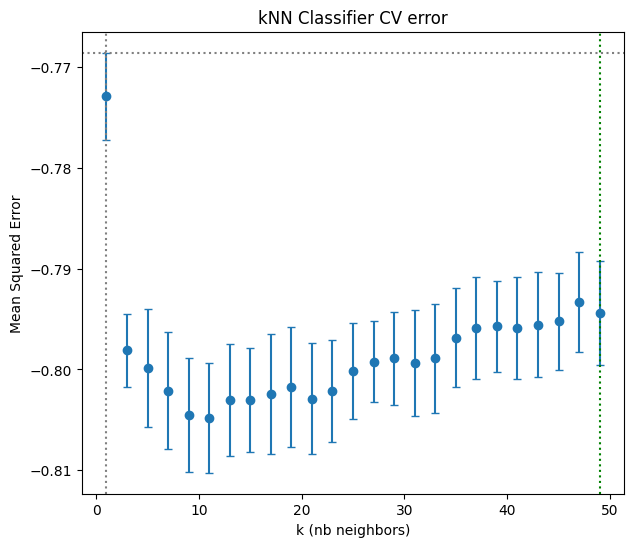

In [59]:
plt.figure(figsize=(7,6))
plt.errorbar(x=k_grid, y=test_accs, yerr=std_test_accs, fmt='o', capsize=3)

plt.axvline(best_k, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_std_rule_best_k, ls='dotted', color="green")#vertical line at best k value according to 1 std err rule
plt.axhline(test_accs[index_best] + std_test_accs[index_best], ls='dotted', color="grey")

plt.title("kNN Classifier CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Mean Squared Error')
plt.show()

# Optimal KNN

In [65]:
knn_pipe_opt = Pipeline([
    ("preprocessor", preprocessor),
    ("knn_model", KNeighborsClassifier(n_neighbors=one_std_rule_best_k))
])
knn_opt = knn_pipe_opt.fit(X_train, y_train)

In [66]:
y_hat = knn_opt.predict(X_train)
y_hat_valid = knn_opt.predict(X_valid)
y_hat_test = knn_opt.predict(X_test)

In [67]:
print("Training accuracy:", accuracy_score(y_hat, y_train))
print("Validation accuracy:", accuracy_score(y_hat_valid, y_valid))
print("Test accuracy:", accuracy_score(y_hat_test, y_test))


Training accuracy: 0.7773699329715927
Validation accuracy: 0.7416232315711094
Test accuracy: 0.7557706626954579
